In [1]:
from google.colab import auth
auth.authenticate_user()

In [ ]:
# # THE DATA
# # ================
# from datasets import load_dataset
# import pandas as pd
# dataset = load_dataset("tweet_eval", "sentiment")
# dataset
# train_data = dataset["train"]
# df = pd.DataFrame(train_data)
# df.head()
# # df_read = pd.read_csv("train_data.csv")


In [2]:
from google.cloud import bigquery
import pandas as pd
df = pd.read_csv("tweet_data.csv")

df.head()


,id,text,label
0,0,"""QT @user In the original draft of the 7th boo...",2
1,1,"""Ben Smith / Smith (concussion) remains out of...",1
2,2,Sorry bout the stream last night I crashed out...,1
3,3,Chase Headley's RBI double in the 8th inning o...,1
4,4,@user Alciato: Bee will invest 150 million in ...,2


In [5]:
client = bigquery.Client()

# table_id = "sentiment-analysis.tweets_sa.tweets"

df.to_gbq("tweets_sa.tweets", project_id="sentiment-analysis-09", if_exists='replace')

/tmp/ipython-input-5-2883377.py:5: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  df.to_gbq("tweets_sa.tweets", project_id="sentiment-analysis-09", if_exists='replace')
100%|██████████| 1/1 [00:00<00:00, 9446.63it/s]


In [ ]:
# %sql

# # some queries in BigQuery console
# SELECT label, COUNT(*) as count
# FROM `sentiment-analysis-09.tweets_sa.tweets`
# GROUP BY label
# ORDER BY count DESC;

# -- ======

# SELECT id, text
# FROM `sentiment-analysis-09.tweets_sa.tweets`
# WHERE label = 0  -- or 1/2 depending on your label schema
# LIMIT 10;

In [12]:
query = """
SELECT label, COUNT(*) as count
FROM `sentiment-analysis-09.tweets_sa.tweets`
GROUP BY label
ORDER BY count DESC
"""
df_result = client.query(query, project="sentiment-analysis-09").to_dataframe()
df_result.plot(kind="bar", x="label", y="count")

<Axes: xlabel='label'>

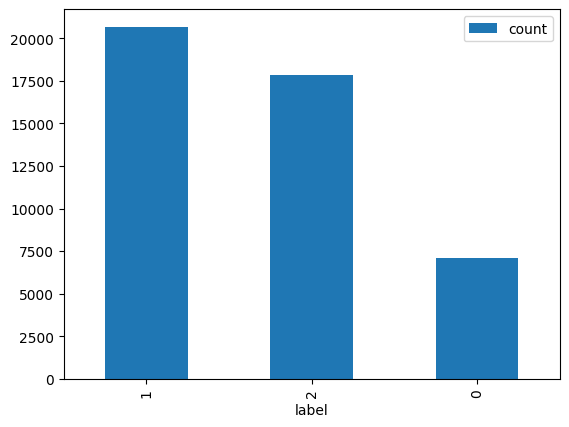

In [11]:
from google.cloud import bigquery

# Ensure project is set correctly
client = bigquery.Client(project="sentiment-analysis-09")

# Query
query = """
SELECT label, COUNT(*) as count
FROM `sentiment-analysis-09.tweets_sa.tweets`
GROUP BY label
ORDER BY count DESC
"""

# Run query
df_result = client.query(query).to_dataframe()

# Plot
df_result.plot(kind="bar", x="label", y="count")

In [13]:
!pip install transformers --quiet

from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_model = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

# Run predictions
predictions = sentiment_model(df["text"].tolist(), truncation=True)

# Extract labels
df["model_label_text"] = [p["label"] for p in predictions]

# Optional: Map text labels to numeric values for evaluation
label_map = {"Neg": 0, "Neutral": 1, "Pos": 2}  # Cardiff model: 0=neg, 1=neutral, 2=pos
df["model_label"] = df["model_label_text"].map(label_map)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


,id,text,label,model_label_text,model_label
0,0,"""QT @user In the original draft of the 7th boo...",2,Pos,2
1,1,"""Ben Smith / Smith (concussion) remains out of...",1,Neutral,1
2,2,Sorry bout the stream last night I crashed out...,1,Neutral,1
3,3,Chase Headley's RBI double in the 8th inning o...,1,Neutral,1
4,4,@user Alciato: Bee will invest 150 million in ...,2,Neutral,1


'"Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"'

In [23]:
from pandas_gbq import to_gbq
# Upload to a new table
to_gbq(df, "tweets_sa.tweets_with_predictions", project_id="sentiment-analysis-09", if_exists="replace")

100%|██████████| 1/1 [00:00<00:00, 7724.32it/s]


In [ ]:
%sql

# SELECT
#   label AS true_label,
#   model_label AS predicted_label,
#   COUNT(*) AS count
# FROM `sentiment-analysis-09.tweets_sa.tweets_with_predictions`
# GROUP BY true_label, predicted_label

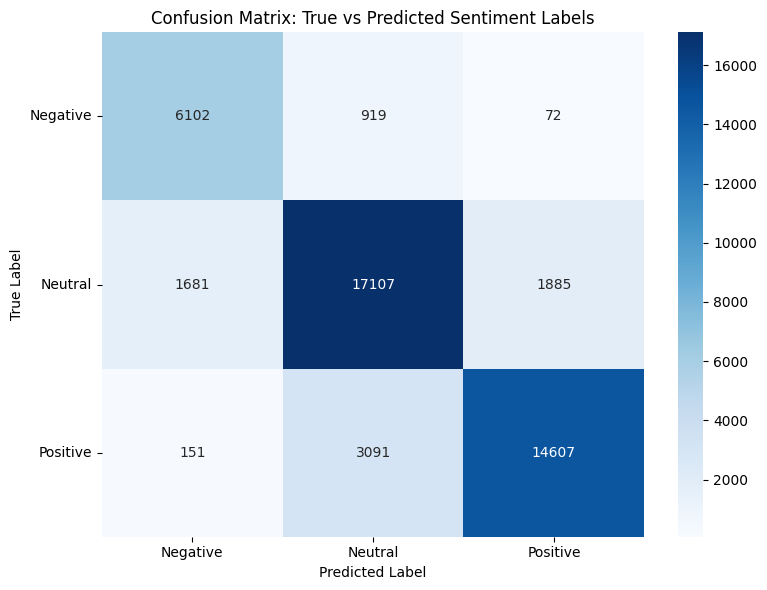

In [25]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# Run query
query = """
SELECT
  label AS true_label,
  model_label AS predicted_label,
  COUNT(*) AS count
FROM `sentiment-analysis-09.tweets_sa.tweets_with_predictions`
GROUP BY true_label, model_label
ORDER BY true_label, predicted_label
"""
df_confusion = client.query(query).to_dataframe()

# Pivot into matrix
conf_matrix = df_confusion.pivot(index='true_label', columns='predicted_label', values='count').fillna(0)
conf_matrix = conf_matrix.astype(int)
# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap="Blues")
plt.title("Confusion Matrix: True vs Predicted Sentiment Labels")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks([0.5, 1.5, 2.5], ["Negative", "Neutral", "Positive"])
plt.yticks([0.5, 1.5, 2.5], ["Negative", "Neutral", "Positive"], rotation=0)
plt.tight_layout()
plt.show()